Cargando y filtrando datos solo para casos de diabetes...
Distribución de clases en el nuevo dataset:
Diabetes_012
2.0    35346
1.0     4631
Name: count, dtype: int64

Iniciando la optimización para el modelo de triaje...
Fitting 3 folds for each of 15 candidates, totalling 45 fits

Búsqueda finalizada. Evaluando el modelo de triaje...

Mejores parámetros encontrados: {'memory': None, 'steps': [('scaler', StandardScaler()), ('smote', SMOTE(k_neighbors=3, random_state=42)), ('classifier', RandomForestClassifier(class_weight='balanced_subsample', max_depth=5,
                       min_samples_leaf=2, n_estimators=200, n_jobs=-1,
                       random_state=42))], 'transform_input': None, 'verbose': False, 'scaler': StandardScaler(), 'smote': SMOTE(k_neighbors=3, random_state=42), 'classifier': RandomForestClassifier(class_weight='balanced_subsample', max_depth=5,
                       min_samples_leaf=2, n_estimators=200, n_jobs=-1,
                       random_state=42), 'sca

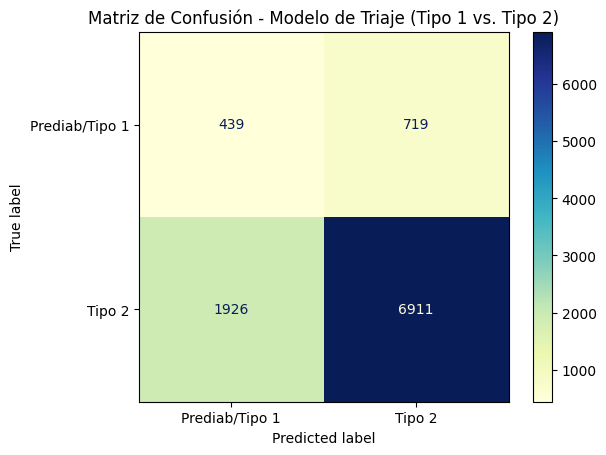

In [3]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
# ¡Importante! Volvemos a necesitar imblearn para SMOTE
# Si no lo tienes instalado en tu entorno local, ejecuta: pip install -U imblearn
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# --- 1. Carga y Filtrado de Datos ---
print("Cargando y filtrando datos solo para casos de diabetes...")
df = pd.read_csv("../Datasets/diabetes_012_health_indicators_BRFSS2015.csv")

# Creamos un nuevo dataframe que CONTIENE ÚNICAMENTE las clases 1.0 y 2.0
df_diabetes_only = df[df['Diabetes_012'] != 0.0].copy()

# La clase 1.0 es Prediabetes/Tipo 1. La 2.0 es Tipo 2.
print("Distribución de clases en el nuevo dataset:")
print(df_diabetes_only['Diabetes_012'].value_counts())

X = df_diabetes_only.drop('Diabetes_012', axis=1)
y = df_diabetes_only['Diabetes_012']


# --- 2. División en Entrenamiento y Prueba ---
# No es necesario un submuestreo grande, usamos todos los datos de diabéticos.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42 # 'stratify' es crucial aquí
)

# --- 3. Pipeline con SMOTE y RandomForest ---
# SMOTE es ideal en este escenario para balancear la clase 1 vs la 2.
pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    # Ajustamos k_neighbors porque la clase 1 tiene pocas muestras.
    ('smote', SMOTE(random_state=42, k_neighbors=3)),
    ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1))
])


# --- 4. Optimización para el Modelo de Triaje ---
print("\nIniciando la optimización para el modelo de triaje...")

# Espacio de parámetros para RandomForest.
param_dist = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [5, 10, 20],
    'classifier__min_samples_leaf': [2, 5, 10],
    'classifier__class_weight': ['balanced', 'balanced_subsample', None]
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Optimizaremos para el 'recall' de la clase minoritaria (1.0)
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=15,
    scoring='recall_macro', # Un buen balance para el recall de ambas clases
    cv=cv,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)


# --- 5. Evaluación del Modelo de Triaje ---
print("\nBúsqueda finalizada. Evaluando el modelo de triaje...")
best_model = random_search.best_estimator_

print(f"\nMejores parámetros encontrados: {best_model.get_params()}")

y_pred = best_model.predict(X_test)

print("\n--- Reporte de Clasificación (1=Prediab/T1, 2=T2) ---\n")
print(classification_report(y_test, y_pred))

print("\nGenerando la matriz de confusión...")
disp = ConfusionMatrixDisplay.from_estimator(
    best_model, X_test, y_test,
    display_labels=['Prediab/Tipo 1', 'Tipo 2'],
    cmap=plt.cm.YlGnBu  # Un color diferente para distinguirlo
)
disp.ax_.set_title("Matriz de Confusión - Modelo de Triaje (Tipo 1 vs. Tipo 2)")
plt.show()
